## Importazione 

In [1]:
import cv2
import tensorflow as tf
import keras
#import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
PATH_BASE = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/npy_files/'
MODELS_PATH = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/h5_files/'

# Load X/Y test e codebook

In [0]:
dataset_splitted_nneigh_pad_augm = np.load(PATH_BASE + "dataset_splitted_nneigh_pad_augm.npz")

In [0]:
x_test = dataset_splitted_nneigh_pad_augm['img_test']
y_test = dataset_splitted_nneigh_pad_augm['mask_test']
normali_test = dataset_splitted_nneigh_pad_augm['normali_nneigh_test']

In [0]:
dataset_pre_processing = np.load(PATH_BASE + "dataset_pre_processing_nneigh_pad.npz")
codebook = dataset_pre_processing['codebook']

# Ricostruzione modello

In [0]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape, SpatialDropout2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from keras import backend as K

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

def ZF_UNET_224(dims, output_mask_channels, weights_file, dropout_val=0.2):
    inputs = Input((dims[0], dims[1], dims[2]))
    axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(output_mask_channels, (1, 1), name = "final")(up_conv_224)
    conv_final = Activation('softmax')(conv_final)

    model = Model(inputs, conv_final, name="ZF_UNET_224")

        #weights_path = get_file(
        #    'zf_unet_224_weights_tf_dim_ordering_tf_generator.h5',
        #    ZF_UNET_224_WEIGHT_PATH,
        #    cache_subdir='models',
        #    file_hash='203146f209baf34ac0d793e1691f1ab7')
    model.load_weights(weights_file, by_name = True)

    return model

In [0]:
# Image dimensions
DIMS = (320,320,3)
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 41
# Pretrained weights
#ZF_UNET_224_WEIGHT_PATH = 'https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model/releases/download/v1.0/zf_unet_224.h5'
ZF_UNET_224_WEIGHT_PATH = "zf_unet_224_nrmest_20200526.h5"

In [0]:
model = ZF_UNET_224(DIMS, OUTPUT_MASK_CHANNELS, MODELS_PATH + ZF_UNET_224_WEIGHT_PATH)

In [0]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
class_weights = np.load(PATH_BASE + "label_weights_nneigh_pad.npy")

In [0]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [14]:
model.compile(optimizer=Adam(), loss=weighted_categorical_crossentropy(class_weights), metrics=[dice_coef, f1])
model.summary()

Model: "ZF_UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 320, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 320, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________________

# Rifiltraggio output togliendo cluster numero 40

Il cluster numero 40 aggiunto per gestire il padding, deve essere rimosso. In particolare, l'immagine viene riportata alle dimensioni originali sulle quali è stato effettuato il clustering. Se un punto interno all'immagine originale presenta come classe individuata il cluster 40, si opera con nearest neighbour per riportarsi nello spazio del cluster originale.

In [0]:
def normalize(probs):
  return probs / sum(probs)

def normalize_pred(outputs):
  outputs_n = np.zeros(outputs.shape)
  for w in range(outpus.shape[0]):
    for h in range(outputs.shape[1]):
      outputs_n[w][h] = normalize(outputs_n[w][h])
  return outputs_n

In [0]:
def unpadding(out_padded):
  out_unpadded = np.zeros((240, 320, 40))
  for h in range(0,out_unpadded.shape[0]):
    for w in range(0,out_unpadded.shape[1]):
      for c in range(0,out_unpadded.shape[2]):
        out_unpadded[h][w][c] = out_padded[h][w][c]
  return out_unpadded

# Ricalcolo superfici normali da classificazione

In [0]:
import scipy as sp
import matplotlib.pyplot as plt
from scipy import spatial

# Triangolazione di delaunay a partire dai 40 centroidi di riferimento.
def get_delaunay_triangulation(codebook):
  tri = sp.spatial.Delaunay(codebook[:,0:2]) # perform triangulation over x and y coordinates (z is function of (x,y))
  #print(tri.simplices)
  #plt.figure()
  #plt.axes().set_aspect('equal')
  #plt.triplot(codebook[:,0], codebook[:,1], tri.simplices.copy())
  #plt.plot(codebook[:,0], codebook[:,1], 'o')
  #plt.show()
  return tri.simplices

In [0]:
# Metodo che permette di ottenere la normale 3d per ogni pixel a partire dalla predizione della rete.
# INPUT
# netPrediction: shape = (H, W, 40). Predizione della rete di un'immagine. 
#                Per ogni pixel la rete fornisce un vettore di 40 probabilità (1 per ogni centroide).
# codebook:      shape = (40,3). Lista delle 40 normali di riferimento (centroidi). codebook.shape = (40,3)
# triangoli:     shape = (N, 3). Triangolazione di delaunay; ogni elemento di questo vettore è una tripla di indici di centroidi, da utilizzare
#                nel codebook ottenuto con la clusterizzazione. (es. N = 67)
# OUTPUT
# norm:          shape = (H, W, 3). Normali 3d pixel per pixel dell'immagine.

def decode(netPrediction, codebook, triangoli):
  h, w = netPrediction.shape[0:2]
  
  # for each triangle, get total prob
  tri_prob = np.dstack([np.sum(netPrediction[:,:,t], axis = -1) for t in triangoli]) 

  # get best tri
  best_tri = np.argmax(tri_prob, axis = -1)
  
  # get coefficients to most probable tri
  alphas = np.reshape([netPrediction[row, col, triangoli[best_tri[row, col]]] for row in range(h) for col in range(w)], (h, w, 3))

  # sum -> 1
  alphas = np.divide(alphas, np.reshape(np.tile(np.sum(alphas, axis = -1), (1,3)), (h, w, 3)))
  alphas = np.reshape(np.tile(alphas, (1,1,3)), (h, w,3,3))  
  alphas = np.swapaxes(alphas, 2,3)

  norm = np.multiply(alphas, codebook[triangoli[best_tri]])
  norm = np.sum(norm, axis = -2)
  
  return norm

In [0]:
y_test_p = []
for n in range(0,x_test.shape[0]):
  y_test_p_n = model.predict(np.array([x_test[n, ]]))
  y_test_p_n = y_test_p_n[0]
  y_test_p_n = unpadding(y_test_p_n)
  y_test_p_n = normalize(y_test_p_n)
  netPrediction_3d = decode(y_test_p_n, codebook, get_delaunay_triangulation(codebook))
  y_test_p.append(netPrediction_3d)
y_test_p = np.asarray(y_test_p)

In [98]:
print("Massimo: {}, minimo: {}".format(np.max(y_test_p), np.min(y_test_p)))

Massimo: 4071.4633731769786, minimo: -4864.214105587595


In [0]:
np.savez_compressed(PATH_BASE + "prediction_test_decoded_20200523.npz", y_test_p = y_test_p)

In [0]:
loaded = np.load(PATH_BASE + "prediction_test_decoded_20200523.npz")
y_test_p = loaded['y_test_p']

In [67]:
y_test_p.shape

(434, 240, 320, 3)

# Visualizzazione

In [0]:
index = np.random.randint(x_test.shape[0])

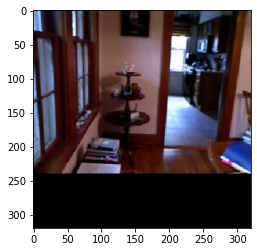

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(x_test[index])

In [75]:
y_test_p[index].shape

(240, 320, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


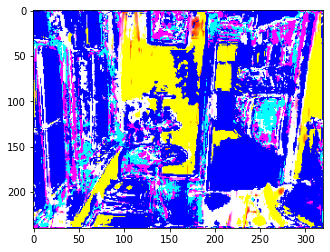

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure('es. predizione decodificata')
plt.imshow(255/2 * y_test_p[index])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


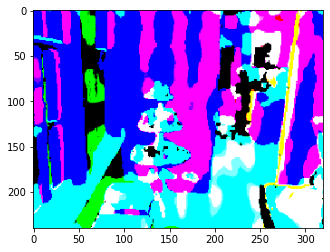

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure('es. predizione decodificata')
plt.imshow(255/2 * normali_test[index])

# Valutazione

## Eval cosine

In [0]:
# pixel wise evaluation
# INPUT
# prediction:   shape = (1,3) normale predetta dalla rete (ottenuta come codifica dalle label)
# ground_truth: shape = (1,3) normale effettiva
# OUTPUT
# l'errore in radianti tra la normale passata e quella effettiva
def eval_cosine(prediction, ground_truth):
  if np.sum(ground_truth) == 0 or np.sum(prediction) == 0:
    return 0
  cosine = np.dot(prediction, ground_truth) / (np.linalg.norm(prediction) * np.linalg.norm(ground_truth))
  if (cosine <= 1 and cosine >= -1):
    return np.arccos(cosine) 
  return np.deg2rad(180) if cosine < -1 else 0

# questa funzione va chiamata su tutti i pixel di tutte le immagini del test-set o validation set.

In [0]:
def eval_cosine_img(img_y, img_gt):
  eval_cosine_img = np.zeros((240,320), dtype=np.uint8)
  for h in range(0, img_y.shape[0]):
    for w in range(0, img_y.shape[1]):
      eval_cosine_img[h][w] = eval_cosine(img_y[h][w], img_gt[h][w])
  return eval_cosine_img

In [0]:
def eval_cosine_all(yp, gt):
  eval_array = []
  for n in range(0,yp.shape[0]):
    eval_array.append(eval_cosine_img(yp[n, ], gt[n, ]))
  return np.asarray(eval_array)

In [0]:
eval_cosine_array = eval_cosine_all(y_test_p, normali_test)

In [0]:
eval_cosine_array.shape

(434, 240, 320)

In [83]:
print("Media: {}, varianza: {}".format(np.mean(eval_cosine_array), np.var(eval_cosine_array)))

Media: 0.7339193308371735, varianza: 0.43680806434502223


In [90]:
np.max(normali_test[0])

1.0

## Soglia errori angolari rispetto a soglie

In [84]:
# TODO: effettuare la predizione su tutto il test-set (es: 30% del dataset "normals_orig.npy") con la rete. 
# Dopodichè decodificare le predizioni per ogni immagine (label -> normali 3d) e possibilmente salvare in un file (es: "prediction_test_decoded.npy").

# NOTA: nel calcolo della metrica non vanno considerati i pixel rumorosi, che sono identificati dalla tripla [0,0,0].
tot_noised_pixel = np.where(np.sum(normali_test, axis = -1) == 0)[0].shape[0]
tot_pixel = normali_test.shape[0] * normali_test.shape[1] * normali_test.shape[2]
valid_pixel = tot_pixel - tot_noised_pixel

theta = y_test_p

print('Noised pixel / Tot pixel (%):', tot_noised_pixel / tot_pixel * 100)
print('Mean: ', np.rad2deg(np.sum(theta) / valid_pixel))

# es: carico da file
#theta = np.load(PATH_BASE + "prediction_test_decoded_20200513.npy")

# valuto la percentuale di errori angolari inferiori rispetto ad una delle seguenti soglie
soglie_errori = [11.25, 22.5, 30]
for th in soglie_errori:
  under_th = (np.where(theta < np.deg2rad(th))[0].shape[0] - tot_noised_pixel) / valid_pixel * 100
  print('Threshold', str(th),  under_th)

Noised pixel / Tot pixel (%): 10.729931715629801
Mean:  77.6444141110565
Threshold 11.25 203.9381833879828
Threshold 22.5 223.34437301428997
Threshold 30 236.74686609229406
